In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import TargetEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, cross_val_predict, cross_validate


from dataframe_encoder import (filter_compositions, filter_singlelayer,
    filter_valid_ratio, CompositionEncoder_DF)

In [2]:
df = pd.read_csv(
    "example_data/psc_all_mz_20240109.csv", index_col=0, low_memory=False)
print("Nrows: ", len(df))

Nrows:  43252


In [3]:
### filter dataset for composition and convert composition to norm'd ratio
composition_dict = {
    "Perovskite_composition_a_ions": "Perovskite_composition_a_ions_coefficients",
    "Perovskite_composition_b_ions": "Perovskite_composition_b_ions_coefficients",
    "Perovskite_composition_c_ions": "Perovskite_composition_c_ions_coefficients",
}
df = df.dropna(
    subset=list(composition_dict.keys())+list(composition_dict.values()))
# filter out multilayer solar cells
df = filter_singlelayer(df, list(composition_dict.keys()))
df = filter_valid_ratio(df, list(composition_dict.values()))

print("Nrows before filtering: ", len(df))
filter_dict = {
    "Perovskite_composition_a_ions": ["Cs", "MA", "FA"],
    "Perovskite_composition_b_ions": ["Pb"],
    "Perovskite_composition_c_ions": ["I", "Br"],
}
ions = []
for ions_site in filter_dict.values():
    ions += ions_site
df_filtered = filter_compositions(df, filter_dict)
print("Nrows after filtering compositions: ", len(df_filtered))
print(df_filtered.value_counts(
    subset=list(composition_dict.keys())))

enc = CompositionEncoder_DF(composition_dict)
df_comp = enc.fit_transform(df_filtered, append=True)
df_comp = df_comp.dropna(subset=ions)
print("Nrows after dropping na columns: ", len(df_filtered))

Nrows before filtering:  42721
Nrows after filtering compositions:  39465
Perovskite_composition_a_ions  Perovskite_composition_b_ions  Perovskite_composition_c_ions
MA                             Pb                             I                                27116
Cs; FA; MA                     Pb                             Br; I                             3799
FA; MA                         Pb                             Br; I                             2870
                                                              I                                  928
Cs                             Pb                             Br; I                              918
Cs; FA                         Pb                             Br; I                              693
MA                             Pb                             Br; I                              618
FA                             Pb                             I                                  581
Cs                        

Perovskite_composition_short_form
CsFAMAPbBrI                          3799
FAMAPbBrI                            2870
FAMAPbI                               928
CsPbBrI                               918
CsFAPbBrI                             693
MAPbBrI                               618
FAPbI                                 581
CsPbBr                                445
CsPbI                                 437
CsFAPbI                               390
MAPbBr                                299
CsFAMAPbI                             108
FAPbBrI                                87
CsMAPbI                                85
FAPbBr                                 40
CsMAPbBrI                              27
CsFAPbBr                               11
FAMAPbBr                                7
CsFAMAPbBr                              6
Name: count, dtype: int64


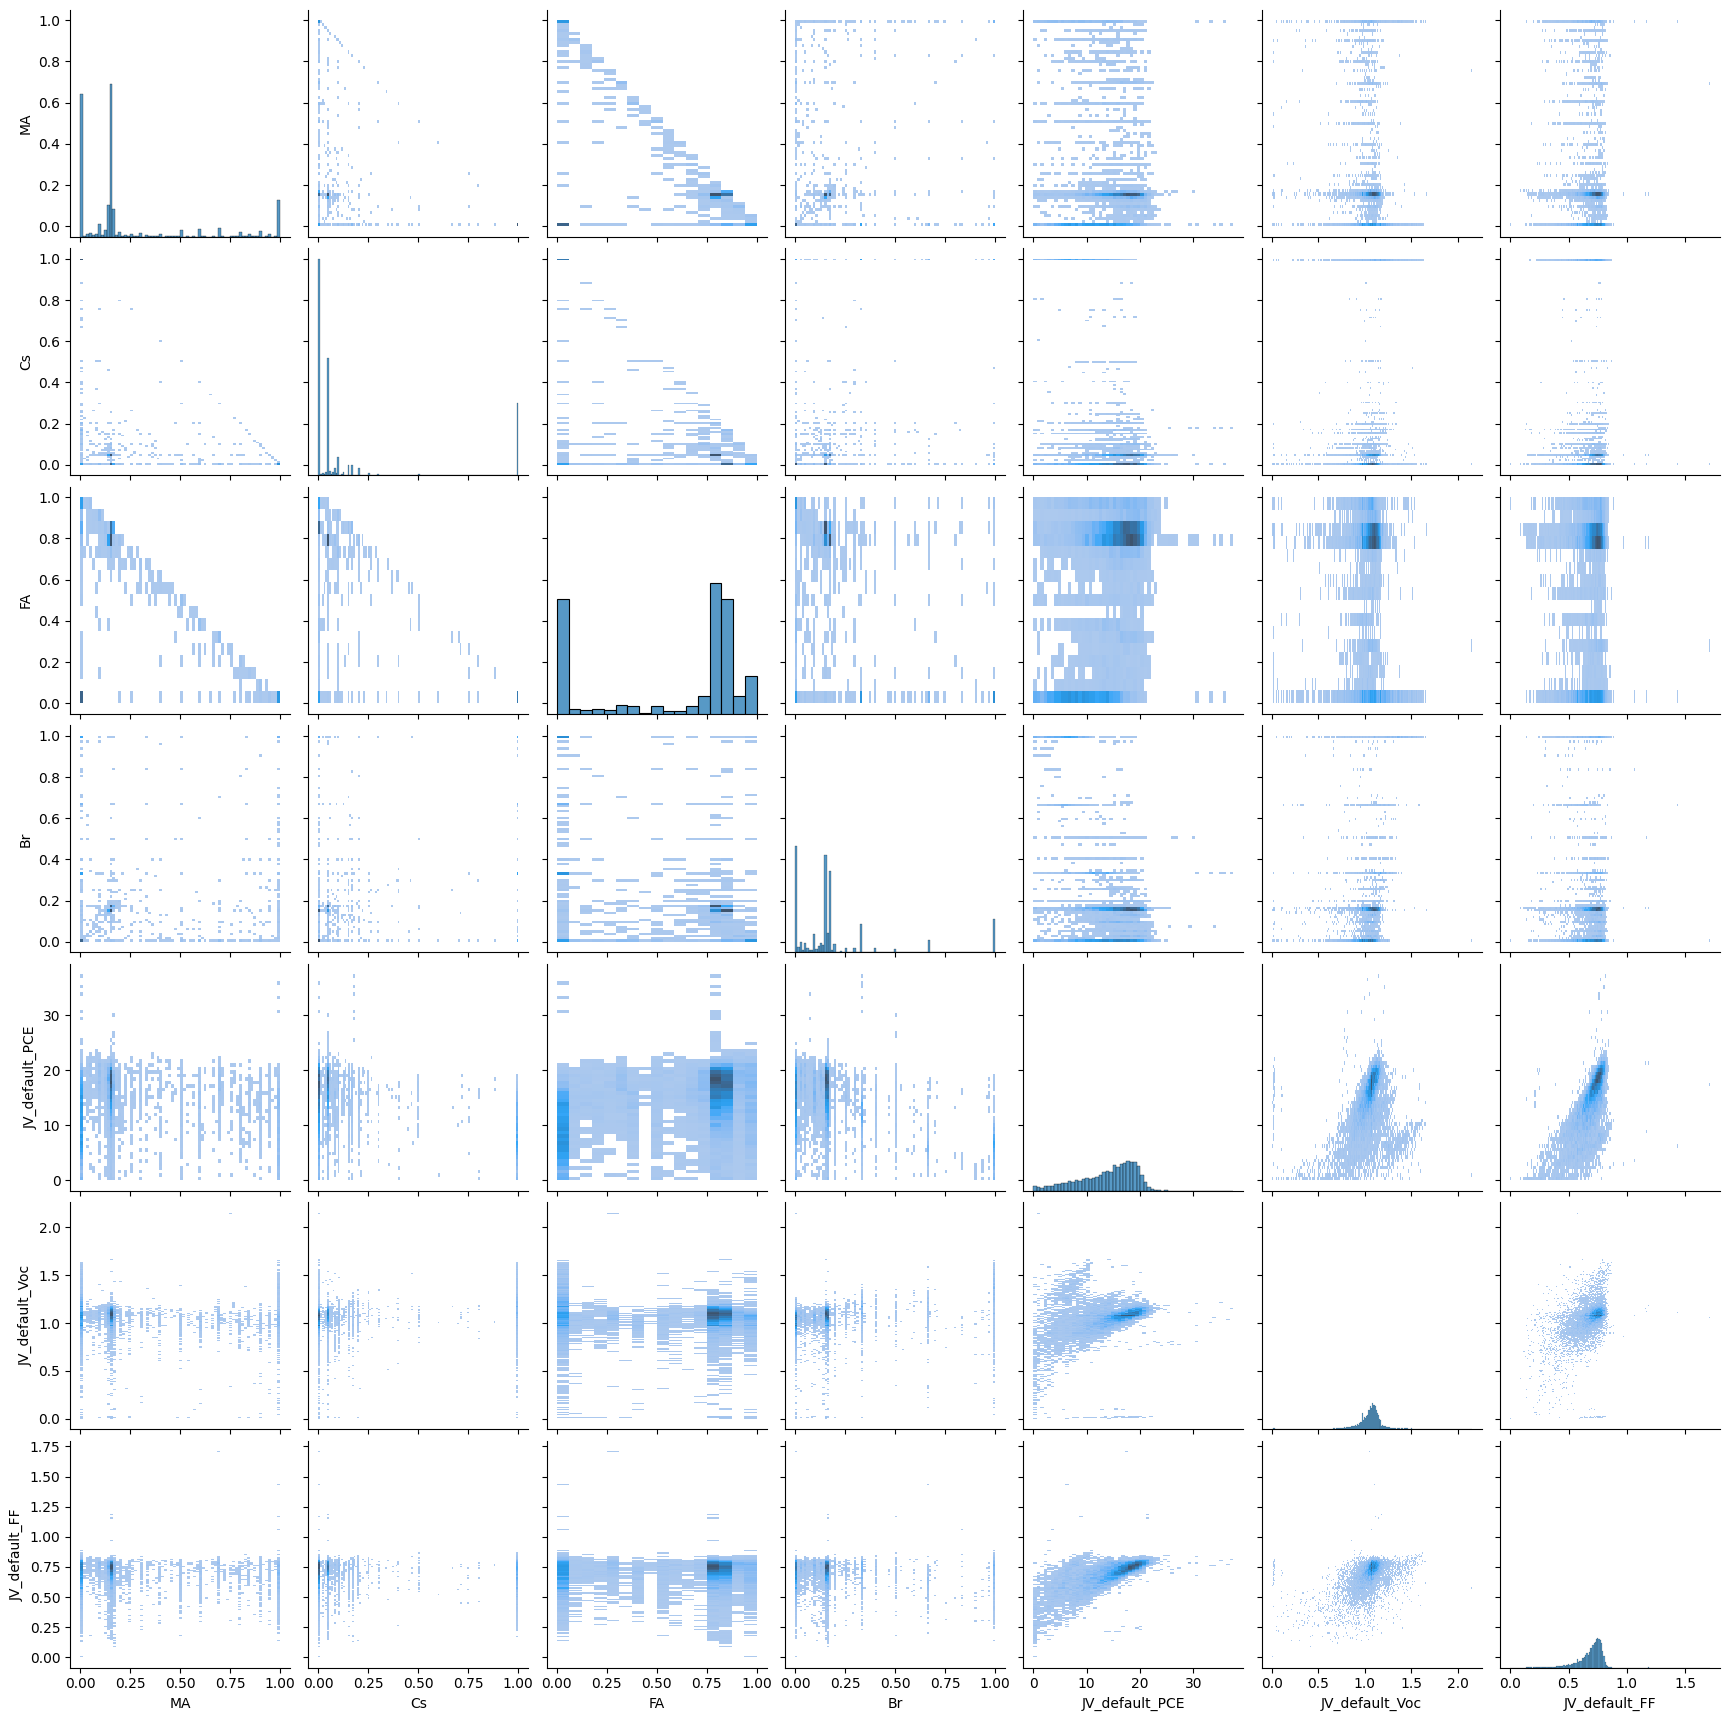

In [8]:
#df_pair = df_comp[df_comp["MA"] < 0.99]
df_pair = df_comp[df_comp["Perovskite_composition_short_form"] != "MAPbI"]
#df_pair = df_comp.copy()
sns.pairplot(data=df_pair, kind="hist",
    vars=["MA", "Cs", "FA", "Br", "JV_default_PCE", "JV_default_Voc", "JV_default_FF"])
print(df_pair.value_counts(subset=["Perovskite_composition_short_form"]))

In [12]:
cols_category = ["Cell_architecture", "HTL_stack_sequence",
    "Substrate_stack_sequence", "ETL_stack_sequence",
    "Backcontact_stack_sequence",]
target = "JV_default_PCE"
cols_composition = ions

regr = RandomForestRegressor(max_depth=100, random_state=0,
        max_features='sqrt', oob_score=True, n_jobs=-1)

df_fit = df_pair.dropna(subset=target)
y = df_fit[target]
enc_cat = TargetEncoder()
X_cat = enc_cat.fit_transform(df_fit[cols_category], y)
X_comp = df_fit[cols_composition].to_numpy()
X_combined = np.concatenate([X_cat, X_comp], axis=1)

cv = KFold(n_splits=5, shuffle=True, random_state=0)
scores = cross_validate(regr, X=X_combined, y=y, cv=cv,
    scoring=['r2', 'neg_mean_absolute_error'], n_jobs=-1,
    return_estimator=True, error_score='raise')
print("Scoring attributes: ", scores.keys())
print("r^2: ", np.mean(scores['test_r2']), "+-", np.std(scores['test_r2']))
maes = -1*scores['test_neg_mean_absolute_error']
print("MAE: ", np.mean(maes), "+-", np.std(maes))

Scoring attributes:  dict_keys(['fit_time', 'score_time', 'estimator', 'test_r2', 'test_neg_mean_absolute_error'])
r^2:  0.5903235534497896 +- 0.017943872126512987
MAE:  2.357394226721939 +- 0.07004124049928978


In [13]:
df_common = df_fit.copy()
print("Nrows before filtering: ", len(df_common))

common_value_dict = {}
for col in cols_category:
    common_value_dict[col] = []
    freq_sum = 0
    count = df_fit[col].value_counts(normalize=True)
    for freq, value in zip(count.values, count.index):
        freq_sum += freq
        common_value_dict[col].append(value)
        if freq_sum > 0.9:
            break
    print("Column filtering: ", col)
    df_common = df_common[df_common[col].map(lambda x: x in common_value_dict[col])]
    print("Nrows left: ", len(df_common))
print("Nrows after filtering: ", len(df_common))

Nrows before filtering:  11965
Column filtering:  Cell_architecture
Nrows left:  11774
Column filtering:  HTL_stack_sequence
Nrows left:  10621
Column filtering:  Substrate_stack_sequence
Nrows left:  10301
Column filtering:  ETL_stack_sequence
Nrows left:  9302
Column filtering:  Backcontact_stack_sequence
Nrows left:  8585
Nrows after filtering:  8585


In [14]:
target = "JV_default_PCE"
cols_composition = ions

regr = RandomForestRegressor(max_depth=100, random_state=0,
        max_features='sqrt', oob_score=True, n_jobs=-1)

y = df_common[target]
enc_cat = TargetEncoder()
X_cat = enc_cat.fit_transform(df_common[cols_category], y)
X_comp = df_common[cols_composition].to_numpy()
X_combined = np.concatenate([X_cat, X_comp], axis=1)

cv = KFold(n_splits=5, shuffle=True, random_state=0)
scores = cross_validate(regr, X=X_combined, y=y, cv=cv,
    scoring=['r2', 'neg_mean_absolute_error'], n_jobs=-1,
    return_estimator=True, error_score='raise')
print("Scoring attributes: ", scores.keys())
print("r^2: ", np.mean(scores['test_r2']), "+-", np.std(scores['test_r2']))
maes = -1*scores['test_neg_mean_absolute_error']
print("MAE: ", np.mean(maes), "+-", np.std(maes))

Scoring attributes:  dict_keys(['fit_time', 'score_time', 'estimator', 'test_r2', 'test_neg_mean_absolute_error'])
r^2:  0.5843601457201315 +- 0.026459340880924845
MAE:  2.3787959635765796 +- 0.05079807505409825


In [19]:
### fitting including band gap input
target = "JV_default_PCE"
cols_composition = ions

regr = RandomForestRegressor(max_depth=100, random_state=0,
        max_features='sqrt', oob_score=True, n_jobs=-1)

df_bg = df_common.dropna(subset="Perovskite_band_gap")
y = df_bg[target]
enc_cat = TargetEncoder()
X_cat = enc_cat.fit_transform(df_bg[cols_category], y)
X_comp = df_bg[cols_composition].to_numpy()
X_bg = df_bg["Perovskite_band_gap"].to_numpy().reshape((-1, 1))
X_combined = np.concatenate([X_cat, X_comp, X_bg], axis=1)

cv = KFold(n_splits=5, shuffle=True, random_state=0)
scores = cross_validate(regr, X=X_combined, y=y, cv=cv,
    scoring=['r2', 'neg_mean_absolute_error'], n_jobs=-1,
    return_estimator=True, error_score='raise')
print("Scoring attributes: ", scores.keys())
print("r^2: ", np.mean(scores['test_r2']), "+-", np.std(scores['test_r2']))
maes = -1*scores['test_neg_mean_absolute_error']
print("MAE: ", np.mean(maes), "+-", np.std(maes))

Scoring attributes:  dict_keys(['fit_time', 'score_time', 'estimator', 'test_r2', 'test_neg_mean_absolute_error'])
r^2:  0.604167492078029 +- 0.03758983400305136
MAE:  2.34341616759797 +- 0.10314371111929595
